# Install detectron2

In [1]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-gk8yul1_
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-gk8yul1_
     |████████████████████████████████| 276kB 3.8MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1-cp36-none-any.whl size=44898 sha256=d6ced33c1a3f918b95bfaf6679fa4e18096acf63da7be7030dd561847f77e66e
  Stored in directory: /tmp/pip-ephem-wheel-cache-pug2a3my/wheels/48/53/79/3c6485543a4455a0006f5db590ab9957622b6227011941de06
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=aeb7a2c7d52aa8d9b69ad4842b93f85ff550839dded965a200c3566606f9579f
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully

'1.5.0+cu101'

In [2]:
!git clone https://github.com/facebookresearch/detectron2 ProjectIreland
!pip install -e ProjectIreland

Cloning into 'ProjectIreland'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 5407 (delta 1), reused 3 (delta 1), pack-reused 5391
Receiving objects: 100% (5407/5407), 2.54 MiB | 2.08 MiB/s, done.
Resolving deltas: 100% (3883/3883), done.
Obtaining file:///content/ProjectIreland
  Running setup.py develop for detectron2


In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Train on a custom COCO dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the fruits nuts segmentation dataset](https://github.com/Tony607/mmdetection_instance_segmentation_demo)
which only has 3 classes: data, fig, and hazelnut.
We'll train a segmentation model from an existing model pre-trained on the COCO dataset, available in detectron2's model zoo.

Note that the COCO dataset does not have the "data", "fig" and "hazelnut" categories.

In [8]:
# !unzip data.zip

Archive:  data.zip
   creating: data/
   creating: data/images/
  inflating: data/images/0.jpg       
  inflating: data/images/1.jpg       
  inflating: data/images/10.jpg      
  inflating: data/images/100.jpg     
  inflating: data/images/1000.jpg    
  inflating: data/images/1001.jpg    
  inflating: data/images/1002.jpg    
  inflating: data/images/1003.jpg    
  inflating: data/images/1004.jpg    
  inflating: data/images/1005.jpg    
  inflating: data/images/1006.jpg    
  inflating: data/images/1007.jpg    
  inflating: data/images/1008.jpg    
  inflating: data/images/1009.jpg    
  inflating: data/images/101.jpg     
  inflating: data/images/1010.jpg    
  inflating: data/images/1011.jpg    
  inflating: data/images/1012.jpg    
  inflating: data/images/1013.jpg    
  inflating: data/images/1014.jpg    
  inflating: data/images/1015.jpg    
  inflating: data/images/1016.jpg    
  inflating: data/images/1017.jpg    
  inflating: data/images/1018.jpg    
  inflating: data/images

In [0]:
# !rm -rf data/images/

Register the fruits_nuts dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


In [0]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("military_image", {}, "./data/military_coco_creation.json", "./data/images")

In [10]:
military_image_metadata = MetadataCatalog.get("military_image")
dataset_dicts = DatasetCatalog.get("military_image")

[06/11 18:55:47 d2.data.datasets.coco]: Loaded 1100 images in COCO format from ./data/military_coco_creation.json


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



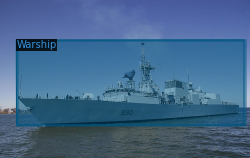

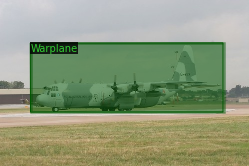

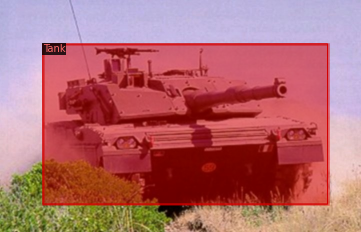

In [11]:
import random

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=military_image_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the fruits_nuts dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU.


In [71]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file("configs/COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("military_image",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.01
cfg.SOLVER.MAX_ITER = 20000    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8  # 3 classes (data, fig, hazelnut)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/11 20:18:33 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (9, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (9,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (32, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (32,) in the model!


[06/11 20:18:34 d2.engine.train_loop]: Starting training from iteration 0
[06/11 20:18:42 d2.utils.events]:  eta: 2:13:51  iter: 19  total_loss: 2.395  loss_cls: 1.775  loss_box_reg: 0.612  loss_rpn_cls: 0.009  loss_rpn_loc: 0.011  time: 0.4015  data_time: 0.0147  lr: 0.000200  max_mem: 6778M
[06/11 20:18:50 d2.utils.events]:  eta: 2:14:03  iter: 39  total_loss: 1.271  loss_cls: 0.600  loss_box_reg: 0.607  loss_rpn_cls: 0.008  loss_rpn_loc: 0.016  time: 0.4044  data_time: 0.0086  lr: 0.000400  max_mem: 6778M
[06/11 20:18:58 d2.utils.events]:  eta: 2:14:43  iter: 59  total_loss: 1.049  loss_cls: 0.423  loss_box_reg: 0.628  loss_rpn_cls: 0.003  loss_rpn_loc: 0.012  time: 0.4065  data_time: 0.0076  lr: 0.000599  max_mem: 6778M
[06/11 20:19:05 d2.utils.events]:  eta: 2:12:04  iter: 79  total_loss: 1.072  loss_cls: 0.426  loss_box_reg: 0.614  loss_rpn_cls: 0.003  loss_rpn_loc: 0.009  time: 0.3971  data_time: 0.0065  lr: 0.000799  max_mem: 6778M
[06/11 20:19:13 d2.utils.events]:  eta: 2:10:3

Now, we perform inference with the trained model on the fruits_nuts dataset. First, let's create a predictor using the model we just trained:



In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # set the testing threshold for this model
cfg.DATASETS.TEST = ("militart_image", )
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

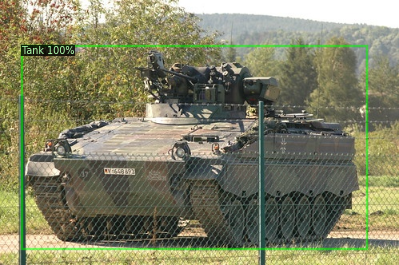

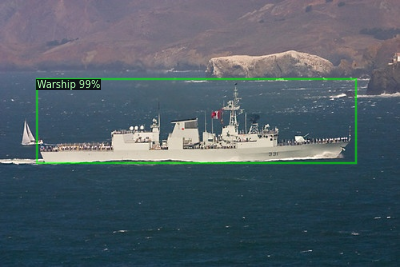

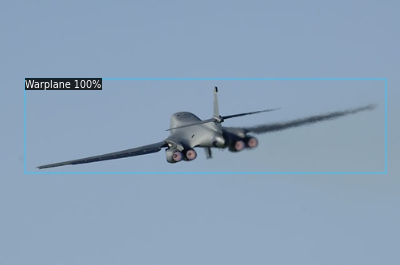

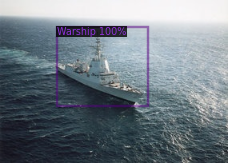

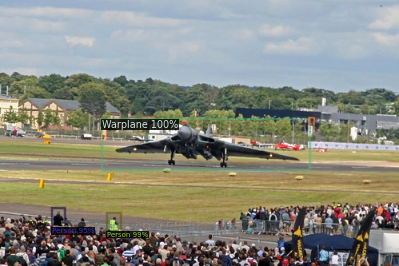

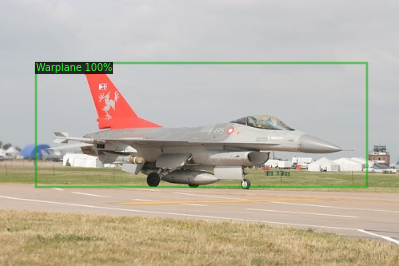

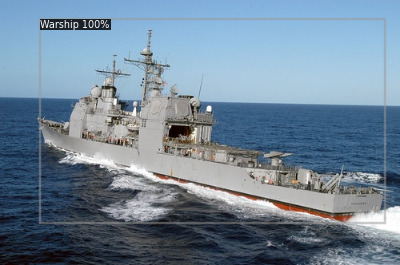

In [100]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 7):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=military_image_metadata, 
                   scale=0.8, 
                  #  instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

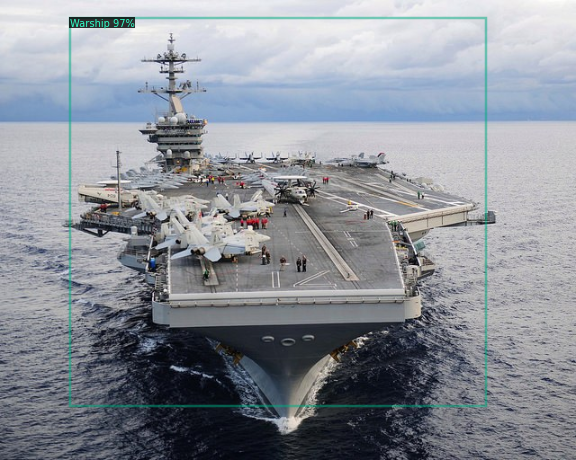

In [102]:
from detectron2.utils.visualizer import ColorMode  
im = cv2.imread('/content/roosevelt.jpg')
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                metadata=military_image_metadata, 
                scale=0.90, 
                # instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [21]:
met 

Metadata(evaluator_type='coco', image_root='./data/images', json_file='./data/military_coco_creation.json', name='military_image', thing_classes=['plane', 'jeep', 'person'], thing_dataset_id_to_contiguous_id={1: 0, 2: 1, 3: 2})

## Benchmark inference speed

In [103]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):0.10,fps:9.91


In [0]:
# !zip -r ProjectIreland.zip /content/ProjectIreland/

In [105]:
# mount it
from google.colab import drive
drive.mount('/content/drive')
# copy it there
# !cp example.txt "/content/drive/My Drive/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
cp: cannot stat 'example.txt': No such file or directory


In [0]:
 !cp -r /content/ProjectIreland/data.zip "/content/drive/My Drive/"